#### Imports and Simple Setup

Python tools we need, set a seed for reproducible results, and show GPU info

In [1]:
# CELL 1: Imports + basic setup
import os, random, math, sys
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import albumentations as A

# Reproducible behavior
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices("GPU"))

TensorFlow version: 2.20.0
GPU available: []


#### Find images and masks

scan the folders (benign, malignant, normal), pair image.png with image_mask.png, and list counts.

In [2]:
# locate image and mask file paths 
BASE_DIR = "Dataset_BUSI_with_GT"   
categories = ["benign", "malignant", "normal"]

image_paths = []
mask_paths = []

for cat in categories:
    cat_dir = os.path.join(BASE_DIR, cat)
    if not os.path.isdir(cat_dir):
        continue
    for fname in sorted(os.listdir(cat_dir)):
        if fname.lower().endswith(".png") and "_mask" not in fname:
            img_p = os.path.join(cat_dir, fname)
            mask_p = os.path.join(cat_dir, fname.replace(".png", "_mask.png"))
            if os.path.exists(mask_p):
                image_paths.append(img_p)
                mask_paths.append(mask_p)

print("Found:", len(image_paths), "image-mask pairs")
# Quick peek
for p in image_paths[:3]:
    print(" ", p)


Found: 780 image-mask pairs
  Dataset_BUSI_with_GT\benign\benign (1).png
  Dataset_BUSI_with_GT\benign\benign (10).png
  Dataset_BUSI_with_GT\benign\benign (100).png


#### A safe Load + Preprocess Function

load image & mask, resize to (256,256), normalize image to [0,1], and make the mask binary 0/1 with dtype float32.

img shape: (256, 256, 3) dtype: float32
mask shape: (256, 256, 1) unique mask values: [0. 1.]


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

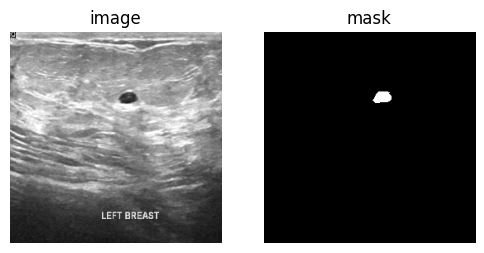

In [3]:
# safe loader + preprocess
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = (256, 256)

def load_preprocess(img_path, mask_path, size=IMG_SIZE):
    # load
    img = load_img(img_path, color_mode="rgb")
    mask = load_img(mask_path, color_mode="grayscale")
    # to array
    img = img_to_array(img).astype(np.float32)
    mask = img_to_array(mask).astype(np.uint8)  # masks often uint8
    # resize
    img = tf.image.resize(img, size).numpy()
    mask = tf.image.resize(mask, size, method="nearest").numpy()
    # normalize image to 0..1
    img = img / 255.0
    # binary mask and float32 with channel dim
    mask = (mask > 127).astype(np.float32)
    if mask.ndim == 2:
        mask = np.expand_dims(mask, -1)
    return img, mask

# quick check on a random example
i = 0
img0, m0 = load_preprocess(image_paths[i], mask_paths[i])
print("img shape:", img0.shape, "dtype:", img0.dtype)
print("mask shape:", m0.shape, "unique mask values:", np.unique(m0))
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img0); plt.title("image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(m0.squeeze(), cmap="gray"); plt.title("mask"); plt.axis("off")


#### Quick visual sanity check of several pairs:

show n random image/mask pairs and an overlay (mask on the image) so you can confirm pairing is correct.


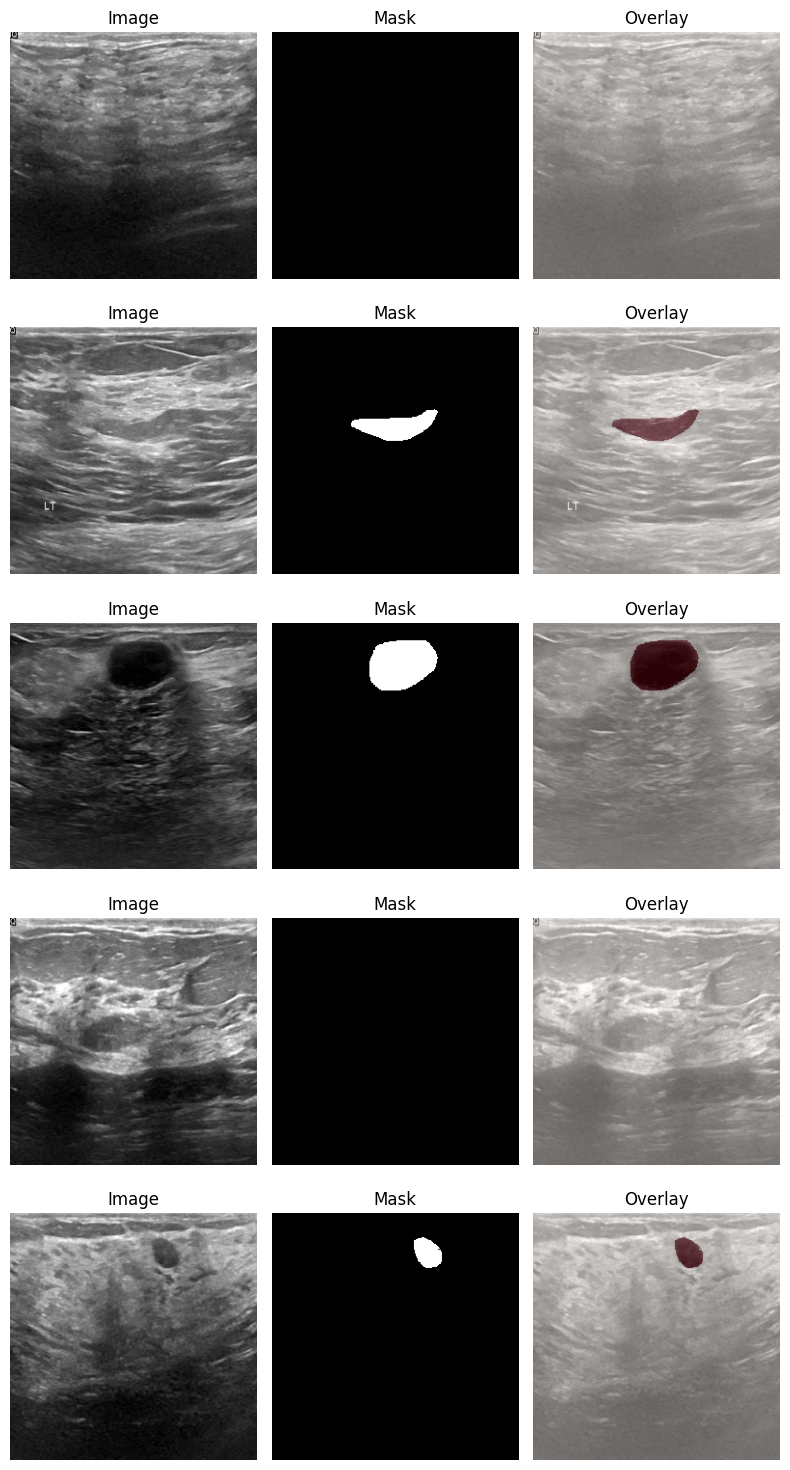

In [4]:
# visualize several examples to ensure pairing is correct
import random
def visualize_pairs(paths_img, paths_mask, n=5):
    idxs = random.sample(range(len(paths_img)), min(n, len(paths_img)))
    plt.figure(figsize=(8, n*3))
    for i, idx in enumerate(idxs):
        img, mask = load_preprocess(paths_img[idx], paths_mask[idx])
        plt.subplot(n, 3, i*3 + 1); plt.imshow(img); plt.title("Image"); plt.axis("off")
        plt.subplot(n, 3, i*3 + 2); plt.imshow(mask.squeeze(), cmap="gray"); plt.title("Mask"); plt.axis("off")
        plt.subplot(n, 3, i*3 + 3); plt.imshow(img); plt.imshow(mask.squeeze(), cmap="Reds", alpha=0.4); plt.title("Overlay"); plt.axis("off")
    plt.tight_layout()

visualize_pairs(image_paths, mask_paths, n=5)


#### Stratified split and simple balancing

split dataset into train/val while keeping category proportions (benign/malignant/normal). Then do a simple duplication oversample on the training set to balance classes (so rare classes get repeated).

In [5]:
# Stratified split and simple oversampling to reduce class imbalance
from sklearn.model_selection import train_test_split

# derive labels from folder name
labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]

train_imgs, val_imgs, train_msks, val_msks, train_lbls, val_lbls = train_test_split(
    image_paths, mask_paths, labels,
    test_size=0.2, random_state=SEED, stratify=labels
)

print("Train:", len(train_imgs), "Val:", len(val_imgs))
print("Train label counts:", Counter(train_lbls))
print("Val label counts:", Counter(val_lbls))

# oversample training so each class has the same number as the largest class
def oversample_to_balance(imgs, msks, lbls):
    cnt = Counter(lbls)
    max_count = max(cnt.values())
    out_imgs, out_msks = [], []
    for cls in cnt:
        cls_indices = [i for i, l in enumerate(lbls) if l == cls]
        cls_imgs = [imgs[i] for i in cls_indices]
        cls_msks = [msks[i] for i in cls_indices]
        repeat = int(np.ceil(max_count / len(cls_imgs)))
        out_imgs.extend(cls_imgs * repeat)
        out_msks.extend(cls_msks * repeat)
    # trim to equalized size and shuffle
    combined = list(zip(out_imgs, out_msks))
    random.shuffle(combined)
    out_imgs, out_msks = zip(*combined)
    return list(out_imgs), list(out_msks)

train_imgs_bal, train_msks_bal = oversample_to_balance(train_imgs, train_msks, train_lbls)
print("Balanced train size:", len(train_imgs_bal))


Train: 624 Val: 156
Train label counts: Counter({'benign': 350, 'malignant': 168, 'normal': 106})
Val label counts: Counter({'benign': 87, 'malignant': 42, 'normal': 27})
Balanced train size: 1278


#### Create data generator (Keras Sequence) with augmentation

create a generator that yields batches to the model. Training generator applies random augmentations; validation generator does not. I use albumentations for realistic augmentations; if you don't want to install it, I include a tiny fallback.

batch shapes: (8, 256, 256, 3) (8, 256, 256, 1)


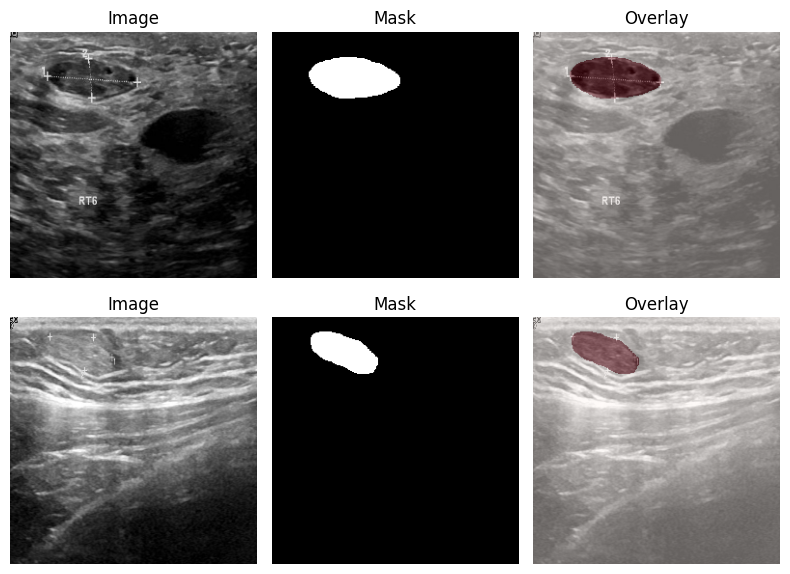

In [10]:
# ------------------------------
# Generator with Albumentations
# ------------------------------
import albumentations as A
from tensorflow.keras.utils import Sequence
import numpy as np

# ------------------------------
# Augmentations
# ------------------------------
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),

    # Affine instead of ShiftScaleRotate
    A.Affine(
        translate_percent=0.05,
        scale=(1 - 0.12, 1 + 0.12),
        rotate=(-20, 20),
        p=0.6
    ),

    A.RandomBrightnessContrast(p=0.5),

    # GaussNoise with no deprecated args
    A.GaussNoise(p=0.3),

    # ElasticTransform without alpha_affine
    A.ElasticTransform(alpha=1.0, sigma=50, p=0.2),

    A.Resize(IMG_SIZE[0], IMG_SIZE[1])
], additional_targets={'mask': 'mask'})


val_aug = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1])
], additional_targets={'mask': 'mask'})


# ------------------------------
# Dataset Generator
# ------------------------------
class BUSIDataset(Sequence):
    def __init__(self, img_paths, mask_paths, batch_size=8, augment=None, shuffle=True):
        super().__init__()
        self.img_paths = list(img_paths)
        self.mask_paths = list(mask_paths)
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.img_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_idxs = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_imgs, batch_msks = [], []

        for i in batch_idxs:
            # load_preprocess should return (H, W, C) float32 image in [0,1] and mask in same H,W
            img, msk = load_preprocess(self.img_paths[i], self.mask_paths[i], size=IMG_SIZE)

            if self.augment:
                aug = self.augment(
                    image=(img * 255).astype(np.uint8),
                    mask=(msk[:, :, 0] * 255).astype(np.uint8)
                )

                img = aug['image'].astype(np.float32) / 255.0
                mask = aug['mask']
                msk = (mask > 127).astype(np.float32)[..., np.newaxis]

            batch_imgs.append(img.astype(np.float32))
            batch_msks.append(msk.astype(np.float32))

        return np.array(batch_imgs, dtype=np.float32), np.array(batch_msks, dtype=np.float32)


# ------------------------------
# Build Dataset Generators
# ------------------------------
BATCH_SIZE = 8
train_gen = BUSIDataset(train_imgs_bal, train_msks_bal, batch_size=BATCH_SIZE, augment=train_aug, shuffle=True)
val_gen   = BUSIDataset(val_imgs, val_msks, batch_size=BATCH_SIZE, augment=val_aug, shuffle=False)


# ------------------------------
# Sanity check
# ------------------------------
imgs, msks = train_gen[0]
print("batch shapes:", imgs.shape, msks.shape)
visualize_pairs([train_imgs_bal[0], train_imgs_bal[1]],
                [train_msks_bal[0], train_msks_bal[1]], n=2)


#### Dice metric and useful losses (Focal Tversky + BCE)

define robust metric and loss functions for segmentation and class imbalance.

In [12]:
# metrics and losses (Dice and Focal Tversky)
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    tp = tf.reduce_sum(y_true_f * y_pred_f)
    fp = tf.reduce_sum((1 - y_true_f) * y_pred_f)
    fn = tf.reduce_sum(y_true_f * (1 - y_pred_f))
    tversky = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)
    return 1.0 - tversky

def focal_tversky(y_true, y_pred, gamma=0.75):
    t = tversky_loss(y_true, y_pred)
    return tf.pow(t, gamma)

# combined loss: BCE + focal_tversky
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    ft = focal_tversky(y_true, y_pred)
    return 0.4 * bce + 0.6 * ft


#### Build U-Net decoder + ResNet50V2 encoder

create the full model by taking a ResNet50V2 pretrained encoder, grabbing intermediate feature maps as skip connections, then building a decoder to upsample back to mask size.

In [26]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50V2

def build_unet_resnet50v2(input_shape=(256,256,3), pretrained=True):
    """
    U-Net with ResNet50V2 backbone.
    Outputs a mask of size IMG_SIZE (256x256) matching your masks.
    """
    # ------------------------------
    # Encoder: ResNet50V2 backbone
    # ------------------------------
    base = ResNet50V2(
        include_top=False,
        weights='imagenet' if pretrained else None,
        input_shape=input_shape
    )

    # ------------------------------
    # Skip connections
    # ------------------------------
    skip_names = [
        "conv4_block6_out",  # 16x16
        "conv3_block4_out",  # 32x32
        "conv2_block3_out",  # 64x64
        "conv1_conv"         # 128x128
    ]
    skips = [base.get_layer(name).output for name in skip_names]
    x = base.output  # 8x8 bottleneck

    # ------------------------------
    # Decoder block helper
    # ------------------------------
    def upsample_concat(x, skip, filters):
        # Upsample by 2
        x = layers.Conv2DTranspose(filters, (2,2), strides=2, padding="same")(x)
        
        # Resize skip to match x using symbolic shape
        h, w = x.shape[1], x.shape[2]
        if h is None or w is None:
            # fallback: use UpSampling2D if symbolic shape unknown
            skip = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(skip)
        else:
            skip = layers.Resizing(h, w, interpolation='bilinear')(skip)
        
        # Concatenate
        x = layers.Concatenate()([x, skip])
        
        # Double conv
        x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        return x

    # ------------------------------
    # Build decoder
    # ------------------------------
    d1 = upsample_concat(x, skips[0], 512)  # 8->16
    d2 = upsample_concat(d1, skips[1], 256) # 16->32
    d3 = upsample_concat(d2, skips[2], 128) # 32->64
    d4 = upsample_concat(d3, skips[3], 64)  # 64->128

    # ------------------------------
    # Final convs + resize to IMG_SIZE
    # ------------------------------
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(d4)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Conv to 1 channel
    x = layers.Conv2D(1, 1, activation="sigmoid", dtype="float32")(x)
    
    # Ensure output size matches mask (IMG_SIZE)
    outputs = layers.Resizing(input_shape[0], input_shape[1])(x)

    # ------------------------------
    # Model
    # ------------------------------
    model = Model(inputs=base.input, outputs=outputs, name="ResNet50V2_UNet")
    return model

# ------------------------------
# Instantiate and check
# ------------------------------
model = build_unet_resnet50v2(pretrained=True)
model.summary()


Model: "ResNet50V2_UNet"

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃                ┃               ┃  Param ┃               ┃
┃ Layer (type)   ┃ Output Shape  ┃      # ┃ Connected to  ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6  │ (None, 256,   │      0 │ -             │
│ (InputLayer)   │ 256, 3)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv1_pad      │ (None, 262,   │      0 │ input_layer_… │
│ (ZeroPadding2… │ 262, 3)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv1_conv     │ (None, 128,   │  9,472 │ conv1_pad[0]… │
│ (Conv2D)       │ 128, 64)      │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ pool1_pad      │ (None, 130,   │      0 │ conv1_conv[0… │
│ (ZeroPadding2… │ 130, 64)      │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ pool1_pool     │ (None, 64,    │      0 │ pool1_pad[0]… │
│ (MaxPooling2D) │ 64, 64)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block1_… │ (None, 64,    │    256 │ pool1_pool[0… │
│ (BatchNormali… │ 64, 64)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block1_… │ (None, 64,    │      0 │ conv2_block1… │
│ (Activation)   │ 64, 64)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block1_… │ (None, 64,    │  4,096 │ conv2_block1… │
│ (Conv2D)       │ 64, 64)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block1_… │ (None, 64,    │    256 │ conv2_block1… │
│ (BatchNormali… │ 64, 64)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block1_… │ (None, 64,    │      0 │ conv2_block1… │
│ (Activation)   │ 64, 64)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block1_… │ (None, 66,    │      0 │ conv2_block1… │
│ (ZeroPadding2… │ 66, 64)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block1_… │ (None, 64,    │ 36,864 │ conv2_block1… │
│ (Conv2D)       │ 64, 64)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block1_… │ (None, 64,    │    256 │ conv2_block1… │
│ (BatchNormali… │ 64, 64)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block1_… │ (None, 64,    │      0 │ conv2_block1… │
│ (Activation)   │ 64, 64)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block1_… │ (None, 64,    │ 16,640 │ conv2_block1… │
│ (Conv2D)       │ 64, 256)      │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block1_… │ (None, 64,    │ 16,640 │ conv2_block1… │
│ (Conv2D)       │ 64, 256)      │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block1_… │ (None, 64,    │      0 │ conv2_block1… │
│ (Add)          │ 64, 256)      │        │ conv2_block1… │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block2_… │ (None, 64,    │  1,024 │ conv2_block1… │
│ (BatchNormali… │ 64, 256)      │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block2_… │ (None, 64,    │      0 │ conv2_block2… │
│ (Activation)   │ 64, 256)      │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block2_… │ (None, 64,    │ 16,384 │ conv2_block2… │
│ (Conv2D)       │ 64, 64)       │        │               │
├────────────────┼───────────────┼────────┼───────────────┤
│ conv2_block2_… │ (None, 64,    │    256 │ conv2_block2… │
│ (BatchNormali… │ 64, 64)       │        │               │
├────────────────┼───────────────┼──────

 Total params: 40,971,361 (156.29 MB)

 Trainable params: 40,922,017 (156.11 MB)

 Non-trainable params: 49,344 (192.75 KB)

#### Phase 1 – Freeze Encoder, Train Decoder

In [27]:
# ------------------------------
# Phase 1: Freeze ResNet50V2 encoder
# ------------------------------
for layer in model.layers:
    # Freeze all layers from ResNet50V2 backbone
    if "resnet" in layer.name.lower():
        layer.trainable = False
    else:
        layer.trainable = True

# Compile with a slightly higher learning rate for decoder training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=combined_loss,
    metrics=[dice_coef]
)

print("Phase 1: Encoder frozen, decoder trainable")

Phase 1: Encoder frozen, decoder trainable


#### Phase 1 – Train Decoder Only

In [28]:
EPOCHS_PHASE1 = 15  # usually 10–20 is enough for decoder
history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.2464 - loss: 0.5941
Epoch 1: val_loss improved from None to 1.41479, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1041s 6s/step - dice_coef: 0.3389 - loss: 0.5235 - val_dice_coef: 0.1007 - val_loss: 1.4148 - learning_rate: 0.0010
Epoch 2/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.4690 - loss: 0.4425
Epoch 2: val_loss improved from 1.41479 to 1.11150, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1017s 6s/step - dice_coef: 0.4767 - loss: 0.4338 - val_dice_coef: 0.3369 - val_loss: 1.1115 - learning_rate: 0.0010
Epoch 3/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.5338 - loss: 0.3984
Epoch 3: val_loss improved from 1.11150 to 0.72362, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 986s 6s/step - dice_coef: 0.5313 - loss: 0.4013 - val_dice_coef: 0.3924 - val_loss: 0.7236 - learning_rate: 0.0010
Epoch 4/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.5497 - loss: 0.3925
Epoch 4: val_loss improved from 0.72362 to 0.63223, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1066s 7s/step - dice_coef: 0.5398 - loss: 0.3962 - val_dice_coef: 0.4464 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 5/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.5477 - loss: 0.3895
Epoch 5: val_loss did not improve from 0.63223
160/160 ━━━━━━━━━━━━━━━━━━━━ 984s 6s/step - dice_coef: 0.5630 - loss: 0.3793 - val_dice_coef: 0.3366 - val_loss: 0.9950 - learning_rate: 0.0010
Epoch 6/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - dice_coef: 0.5758 - loss: 0.3709
Epoch 6: val_loss improved from 0.63223 to 0.39074, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1093s 7s/step - dice_coef: 0.5704 - loss: 0.3741 - val_dice_coef: 0.5826 - val_loss: 0.3907 - learning_rate: 0.0010
Epoch 7/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - dice_coef: 0.5686 - loss: 0.3787
Epoch 7: val_loss did not improve from 0.39074
160/160 ━━━━━━━━━━━━━━━━━━━━ 1243s 8s/step - dice_coef: 0.5637 - loss: 0.3795 - val_dice_coef: 0.5134 - val_loss: 0.4616 - learning_rate: 0.0010
Epoch 8/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - dice_coef: 0.6269 - loss: 0.3395
Epoch 8: val_loss improved from 0.39074 to 0.35252, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1191s 7s/step - dice_coef: 0.6193 - loss: 0.3439 - val_dice_coef: 0.6379 - val_loss: 0.3525 - learning_rate: 0.0010
Epoch 9/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6071 - loss: 0.3473
Epoch 9: val_loss did not improve from 0.35252
160/160 ━━━━━━━━━━━━━━━━━━━━ 930s 6s/step - dice_coef: 0.6041 - loss: 0.3515 - val_dice_coef: 0.6061 - val_loss: 0.3950 - learning_rate: 0.0010
Epoch 10/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6111 - loss: 0.3530
Epoch 10: val_loss did not improve from 0.35252
160/160 ━━━━━━━━━━━━━━━━━━━━ 949s 6s/step - dice_coef: 0.6029 - loss: 0.3531 - val_dice_coef: 0.6464 - val_loss: 0.3789 - learning_rate: 0.0010
Epoch 11/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6229 - loss: 0.3383
Epoch 11: val_loss improved from 0.35252 to 0.34415, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 943s 6s/step - dice_coef: 0.6231 - loss: 0.3370 - val_dice_coef: 0.6616 - val_loss: 0.3442 - learning_rate: 0.0010
Epoch 12/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6301 - loss: 0.3361
Epoch 12: val_loss did not improve from 0.34415
160/160 ━━━━━━━━━━━━━━━━━━━━ 947s 6s/step - dice_coef: 0.6304 - loss: 0.3338 - val_dice_coef: 0.6440 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 13/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.5978 - loss: 0.3515
Epoch 13: val_loss did not improve from 0.34415
160/160 ━━━━━━━━━━━━━━━━━━━━ 949s 6s/step - dice_coef: 0.6185 - loss: 0.3417 - val_dice_coef: 0.6032 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 14/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6279 - loss: 0.3331
Epoch 14: val_loss did not improve from 0.34415
160/160 ━━━━━━━━━━━━━━━━━━━━ 941s 6s/step - dice_coef: 0.6258 - loss: 0.3381 - val_dice_coef: 0.6452 - val_loss: 0.3585 - learning_rate: 0.0010
Epoch 15/15
160/160

#### Unfreeze all Layers

In [29]:
for layer in model.layers:
    layer.trainable = True

#### Recompile with a LOWER learning rate

Fine-tuning requires a small LR (otherwise you destroy the pretrained ResNet weights).

In [31]:
from keras.optimizers import Adam

model.compile(
    optimizer=Adam(5e-5),  # 0.00005
    loss=combined_loss,
    metrics=[dice_coef]
)

#### Phase 2 training

In [32]:
EPOCHS_PHASE2 = 20

history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6577 - loss: 0.3142
Epoch 1: val_loss improved from 0.34415 to 0.32102, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1039s 6s/step - dice_coef: 0.6590 - loss: 0.3106 - val_dice_coef: 0.6770 - val_loss: 0.3210 - learning_rate: 5.0000e-05
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6649 - loss: 0.3053
Epoch 2: val_loss improved from 0.32102 to 0.31845, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 952s 6s/step - dice_coef: 0.6674 - loss: 0.3049 - val_dice_coef: 0.6829 - val_loss: 0.3185 - learning_rate: 5.0000e-05
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6434 - loss: 0.3221
Epoch 3: val_loss did not improve from 0.31845
160/160 ━━━━━━━━━━━━━━━━━━━━ 958s 6s/step - dice_coef: 0.6598 - loss: 0.3098 - val_dice_coef: 0.6852 - val_loss: 0.3194 - learning_rate: 5.0000e-05
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6667 - loss: 0.3055
Epoch 4: val_loss improved from 0.31845 to 0.31796, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 944s 6s/step - dice_coef: 0.6734 - loss: 0.2993 - val_dice_coef: 0.6888 - val_loss: 0.3180 - learning_rate: 5.0000e-05
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6785 - loss: 0.2934
Epoch 5: val_loss did not improve from 0.31796
160/160 ━━━━━━━━━━━━━━━━━━━━ 940s 6s/step - dice_coef: 0.6659 - loss: 0.3053 - val_dice_coef: 0.6897 - val_loss: 0.3191 - learning_rate: 5.0000e-05
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6905 - loss: 0.2861
Epoch 6: val_loss did not improve from 0.31796
160/160 ━━━━━━━━━━━━━━━━━━━━ 961s 6s/step - dice_coef: 0.6893 - loss: 0.2870 - val_dice_coef: 0.6941 - val_loss: 0.3182 - learning_rate: 5.0000e-05
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - dice_coef: 0.6836 - loss: 0.2966
Epoch 7: val_loss improved from 0.31796 to 0.31284, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1116s 7s/step - dice_coef: 0.6887 - loss: 0.2913 - val_dice_coef: 0.6961 - val_loss: 0.3128 - learning_rate: 5.0000e-05
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - dice_coef: 0.6884 - loss: 0.2855
Epoch 8: val_loss improved from 0.31284 to 0.31181, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1102s 7s/step - dice_coef: 0.6750 - loss: 0.2973 - val_dice_coef: 0.6935 - val_loss: 0.3118 - learning_rate: 5.0000e-05
Epoch 9/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6495 - loss: 0.3195
Epoch 9: val_loss improved from 0.31181 to 0.31025, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 979s 6s/step - dice_coef: 0.6826 - loss: 0.2911 - val_dice_coef: 0.7032 - val_loss: 0.3102 - learning_rate: 5.0000e-05
Epoch 10/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6665 - loss: 0.2989
Epoch 10: val_loss improved from 0.31025 to 0.30935, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 962s 6s/step - dice_coef: 0.6830 - loss: 0.2935 - val_dice_coef: 0.7004 - val_loss: 0.3093 - learning_rate: 5.0000e-05
Epoch 11/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6976 - loss: 0.2816
Epoch 11: val_loss did not improve from 0.30935
160/160 ━━━━━━━━━━━━━━━━━━━━ 964s 6s/step - dice_coef: 0.6820 - loss: 0.2922 - val_dice_coef: 0.7005 - val_loss: 0.3137 - learning_rate: 5.0000e-05
Epoch 12/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6934 - loss: 0.2929
Epoch 12: val_loss did not improve from 0.30935
160/160 ━━━━━━━━━━━━━━━━━━━━ 965s 6s/step - dice_coef: 0.6914 - loss: 0.2849 - val_dice_coef: 0.7016 - val_loss: 0.3102 - learning_rate: 5.0000e-05
Epoch 13/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.7041 - loss: 0.2819
Epoch 13: val_loss did not improve from 0.30935
160/160 ━━━━━━━━━━━━━━━━━━━━ 1042s 7s/step - dice_coef: 0.7010 - loss: 0.2798 - val_dice_coef: 0.7029 - val_loss: 0.3117 - learning_rate: 5.0000e-05
Ep

160/160 ━━━━━━━━━━━━━━━━━━━━ 954s 6s/step - dice_coef: 0.7043 - loss: 0.2787 - val_dice_coef: 0.7051 - val_loss: 0.3090 - learning_rate: 5.0000e-05
Epoch 15/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.7202 - loss: 0.2610
Epoch 15: val_loss did not improve from 0.30898
160/160 ━━━━━━━━━━━━━━━━━━━━ 938s 6s/step - dice_coef: 0.7075 - loss: 0.2750 - val_dice_coef: 0.6969 - val_loss: 0.3144 - learning_rate: 5.0000e-05
Epoch 16/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.7084 - loss: 0.2734
Epoch 16: val_loss improved from 0.30898 to 0.30661, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 941s 6s/step - dice_coef: 0.7018 - loss: 0.2784 - val_dice_coef: 0.7063 - val_loss: 0.3066 - learning_rate: 5.0000e-05
Epoch 17/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6833 - loss: 0.2907
Epoch 17: val_loss improved from 0.30661 to 0.30415, saving model to unet_resnet50v2_best.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 941s 6s/step - dice_coef: 0.6871 - loss: 0.2878 - val_dice_coef: 0.7107 - val_loss: 0.3041 - learning_rate: 5.0000e-05
Epoch 18/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - dice_coef: 0.7141 - loss: 0.2691
Epoch 18: val_loss did not improve from 0.30415
160/160 ━━━━━━━━━━━━━━━━━━━━ 1089s 7s/step - dice_coef: 0.7106 - loss: 0.2701 - val_dice_coef: 0.7127 - val_loss: 0.3070 - learning_rate: 5.0000e-05
Epoch 19/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - dice_coef: 0.6851 - loss: 0.2855
Epoch 19: val_loss did not improve from 0.30415
160/160 ━━━━━━━━━━━━━━━━━━━━ 1219s 8s/step - dice_coef: 0.7084 - loss: 0.2733 - val_dice_coef: 0.7130 - val_loss: 0.3059 - learning_rate: 5.0000e-05
Epoch 20/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - dice_coef: 0.7041 - loss: 0.2778
Epoch 20: val_loss did not improve from 0.30415
160/160 ━━━━━━━━━━━━━━━━━━━━ 1090s 7s/step - dice_coef: 0.7086 - loss: 0.2727 - val_dice_coef: 0.7084 - val_loss: 0.3048 - learning_rate: 5.0000e-05


#### plotting the combined training curves.

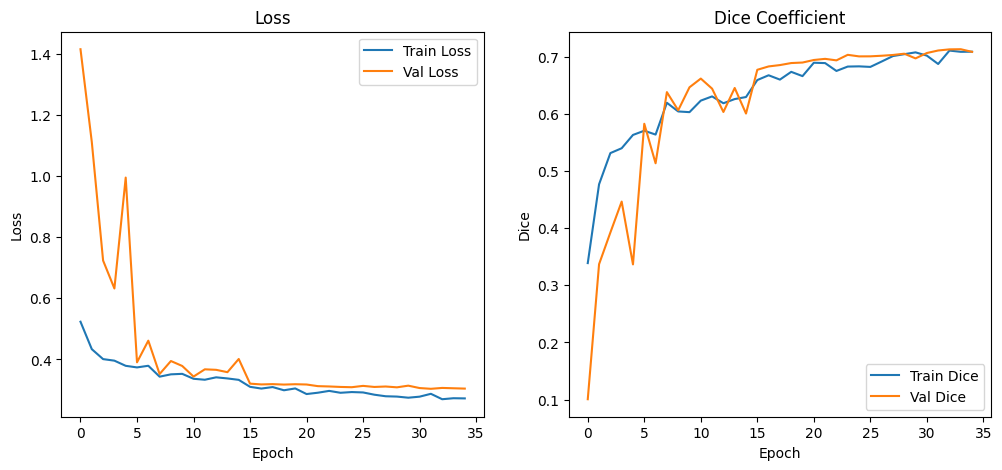

In [33]:
# Combine training histories for plotting
loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']
dice = history_phase1.history['dice_coef'] + history_phase2.history['dice_coef']
val_dice = history_phase1.history.get('val_dice_coef', []) + history_phase2.history.get('val_dice_coef', [])

plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Dice plot
plt.subplot(1,2,2)
plt.plot(dice, label='Train Dice')
plt.plot(val_dice, label='Val Dice')
plt.title("Dice Coefficient")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()

plt.show()


In [38]:
model.save(os.path.join("models", "unet_resnet50v2_final.keras"))


#### Evaluate the final model

In [35]:
eval_results = model.evaluate(val_gen)
print("\nFinal Evaluation on Validation Set:")
for name, value in zip(model.metrics_names, eval_results):
    print(f"{name}: {value:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 952ms/step - dice_coef: 0.7107 - loss: 0.3041

Final Evaluation on Validation Set:
loss: 0.3041
compile_metrics: 0.7107


#### Visualize predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


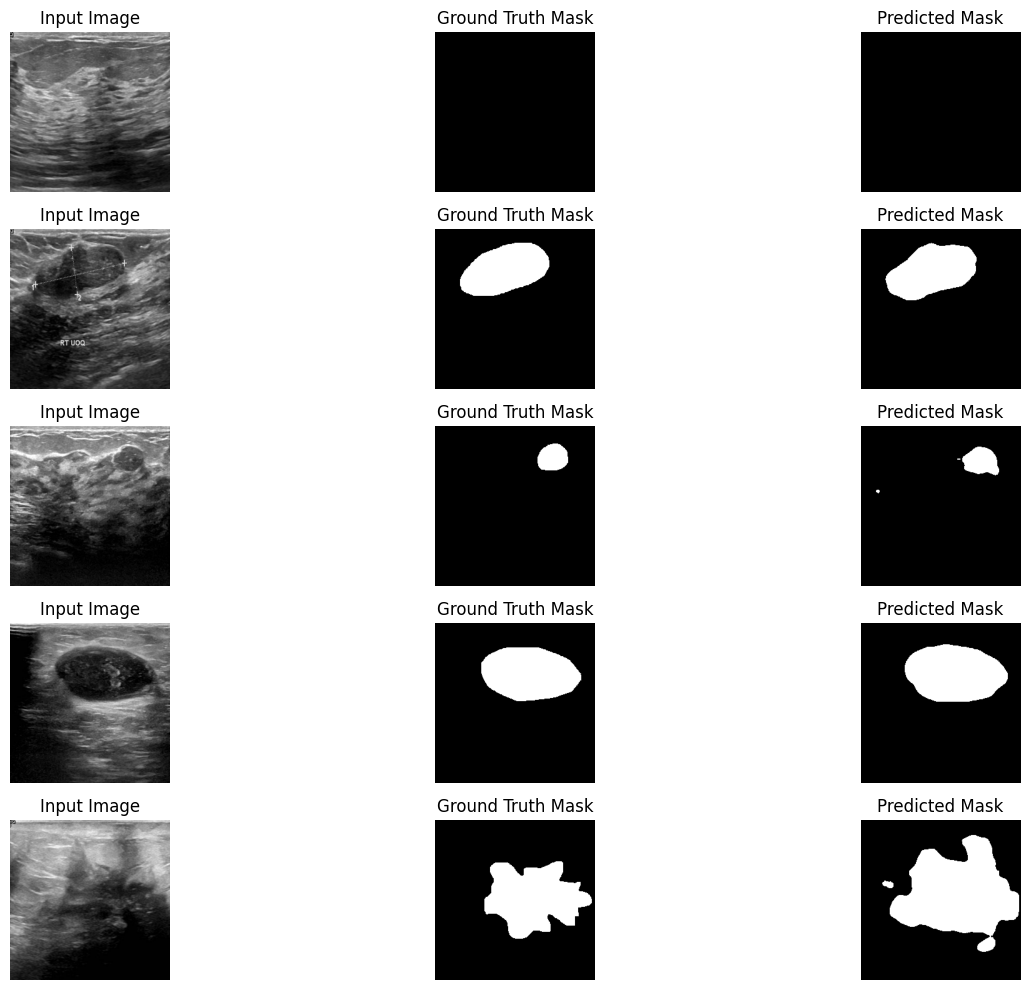

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch
images, masks = next(iter(val_gen))

# Run prediction on the batch
preds = model.predict(images)
preds = (preds > 0.5).astype(np.uint8)  # threshold

# Visualize first 5 samples
num_samples = 5
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(images[i])
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [39]:
import os
import cv2
import numpy as np

SAVE_DIR = "validation_images"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Saving validation images to:", SAVE_DIR)

for i, img_path in enumerate(val_imgs):
    # Load using your existing loader
    img, _ = load_preprocess(img_path, val_msks[i], size=IMG_SIZE)

    # Undo normalization (0–1 → 0–255)
    img_uint8 = (img * 255).astype(np.uint8)

    # Build filename
    filename = f"val_{i:04d}.png"
    save_path = os.path.join(SAVE_DIR, filename)

    # Save PNG
    cv2.imwrite(save_path, cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR))

print("Done! Saved", len(val_imgs), "validation images.")


Saving validation images to: validation_images
Done! Saved 156 validation images.
